In [1]:
# The aim of this notebook is to reproduce the outputs of the following notebook in Pytorch:
# https://www.tensorflow.org/tutorials/structured_data/time_series
# Some of the markdown comments are borrowed from the original notebook.

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from zipfile import ZipFile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#------------------
sys.path.append("..")
from scripts.dataset import TimeSeriesDatasetMature

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
if not os.path.exists('data/jena_climate_2009_2016.csv'):
    !curl -o data/jena_climate_2009_2016.csv.zip https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
    with ZipFile('data/jena_climate_2009_2016.csv.zip', 'r') as zf:
        zf.extractall('data/')

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [4]:
df = pd.read_csv('data/jena_climate_2009_2016.csv')
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

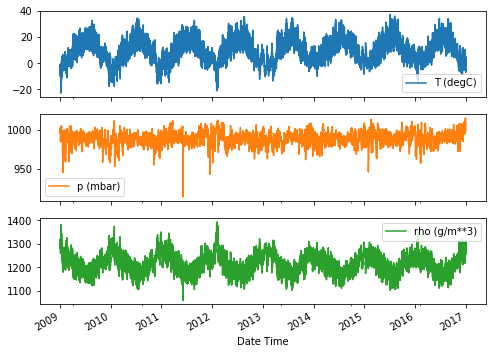

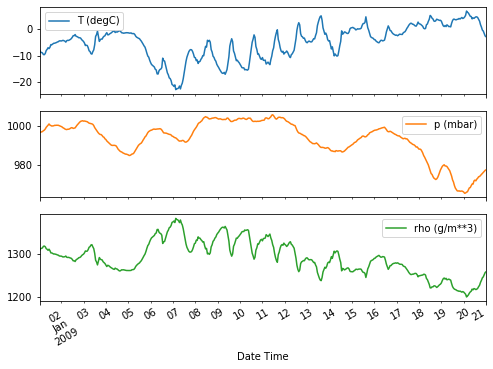

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

This will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [11]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

### Split the data

In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

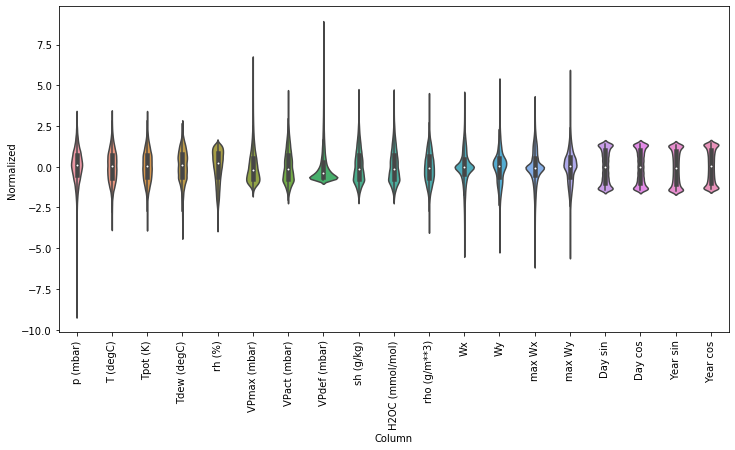

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Build the dataset

In [15]:
input_width = 6
label_width = 4
shift = 6
batch_size = 16
feature_columns=['p (mbar)', 'rho (g/m**3)']
label_columns=['T (degC)']
window_size = input_width + shift

In [16]:
time_Series_dataset = TimeSeriesDatasetMature(train_df, input_width=input_width, label_width=label_width, 
                                              shift=shift, feature_columns=feature_columns,
                                              label_columns=label_columns)
trainloader = DataLoader(time_Series_dataset, batch_size=batch_size, shuffle=True)
len(trainloader)

3066

torch.Size([16, 12, 2]) torch.Size([16, 6, 1]) torch.Size([16, 4, 1])


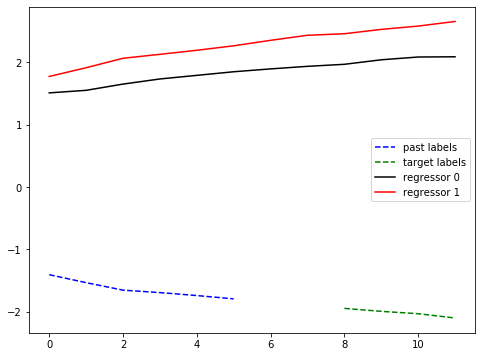

In [17]:
(signal, past_labels, targets) = next(iter(trainloader))
print(signal.size(), past_labels.size(), targets.size())
sample_idx = 0
# plot the past labels in the sample [sample_idx] from the minibatch
plt.plot(range(0, input_width), past_labels[sample_idx].data.numpy(), 
         color='b', linestyle='dashed', label='past labels')
# plot the target label in the sample sample_idx from the minibatch
plt.plot(range(window_size - label_width, window_size), targets[sample_idx].data.numpy(), 
         color='g', linestyle='dashed', label='target labels')
# plot some other extra regressors
plt.plot(signal[sample_idx, :, 0].view(-1).data.numpy(), color='k', label='regressor 0')  
plt.plot(signal[sample_idx, :, 1].view(-1).data.numpy(), color='r', label='regressor 1')   
plt.legend();

# Forecating Models

## Many-to-Many mapping using Conv1D and Linear layers

In [18]:
class TSA_many_to_many_conv(nn.Module):
    def __init__(self, label_width, in_channels, window_length):
        super().__init__()
        layers = []
        layers.append(nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1))
        layers.append(nn.ReLU6())
        layers.append(nn.BatchNorm1d(32))
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Flatten(1))
        layers.append(nn.Linear(in_features=32*window_length, out_features=32))
        layers.append(nn.ReLU6())
        layers.append(nn.BatchNorm1d(32))
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Linear(in_features=32, out_features=label_width))
        self.net = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.net:
#             print(layer, x.shape)
#             import pdb; pdb.set_trace()
            x = layer(x)
        return x

### Training the above model on the training set

In [ ]:
model = TSA_many_to_many_conv(label_width, len(feature_columns), window_size)
lr = 0.001
wd = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
loss_vec = []
reset_loss_every = 300
n_epochs = 2
device = "cpu"

model.to(device)
model.train()

window_size = input_width + shift

for epoch in range(n_epochs+1):
    loss_epoch = 0
    num_samples = 0

    for it, (signal, past_labels, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        signal_reshaped = signal.permute(0, 2, 1)  # Input to Cnov1d should be of size: (B, channels, length). 
        # Here channels is in fact number of features/regressors amd length is size of the signal passed into the conv.
        output = model(signal_reshaped.float().to(device))
        targets = targets.view(output.size()[0], -1).float().to(device)
        loss = F.mse_loss(output, targets)
        num_samples += output.size()[0]
        loss_epoch += loss.item() * output.size()[0]
        loss.backward()
        optimizer.step()
        
        if (it % reset_loss_every) == 0:
            print(f"epoch: {epoch}, it: {it}, average_loss: {loss_epoch/num_samples}")
            loss_epoch = 0
            num_samples = 0

#     print(f"epoch: {epoch}, num_samples: {num_samples}, average_loss: {loss_epoch / num_samples}")

    if (epoch % (n_epochs//2)) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

# Save the model and weights
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, './weights/weights_many_to_many_conv.pth')

### Evaluation on the validation set

In [20]:
time_Series_dataset_valid = TimeSeriesDatasetMature(val_df, input_width=input_width, label_width=label_width, 
                                              shift=shift, feature_columns=feature_columns,
                                              label_columns=label_columns)
validloader = DataLoader(time_Series_dataset_valid, batch_size=batch_size, shuffle=True)
len(validloader)

876

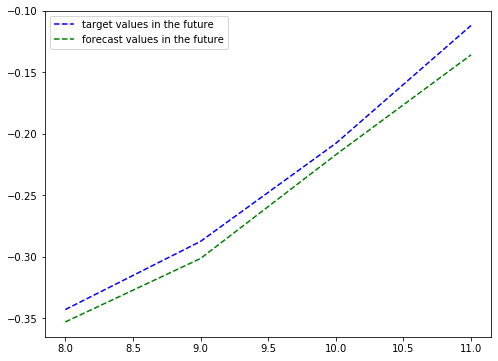

In [40]:
model.to(device)
model.eval()

window_size = input_width + shift

for it, (signal, past_labels, targets) in enumerate(validloader):
    signal_reshaped = signal.permute(0, 2, 1) 
    output = model(signal_reshaped.float().to(device))
    targets = targets.view(output.size()[0], -1).float().to(device)
    loss = F.mse_loss(output, targets)
    num_samples += output.size()[0]
    loss_epoch += loss.item() * output.size()[0]
    
    plt.plot(range(window_size - label_width, window_size), targets[0].view(-1).data.numpy(), 
         color='b', linestyle='dashed', label='target values in the future')  
    plt.plot(range(window_size - label_width, window_size), output[0].view(-1).data.numpy(), 
         color='g', linestyle='dashed', label='forecast values in the future')
    plt.legend();
    break

## Many-to-Many model, taking into account the previous labels 

This model has two internal branches; net1 and net2. Net1 maps the features/regressors (with the time-length of window_size) into a feature encoding, whereas net2 encodes the previous labels that are observed up to the beginning of the forecast period (with the time-length of input_size). Net_out maps the concatenattion of these two branches into the output_layer.

In [87]:
class TSA_m2m_with_past_labels(nn.Module):
    def __init__(self, label_width, in_channels, window_length, past_labels_length):
        super().__init__()
        layers1 = []
        layers1.append(nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1))
        layers1.append(nn.ReLU6())
        layers1.append(nn.BatchNorm1d(32))
        layers1.append(nn.Dropout(0.1))
        layers1.append(nn.Flatten(1))
        layers1.append(nn.Linear(in_features=32*window_length, out_features=32))
        self.net1 = nn.ModuleList(layers1)

        layers2 = []
        layers2.append(nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1))
        layers2.append(nn.ReLU6())
        layers2.append(nn.BatchNorm1d(32))
        layers2.append(nn.Dropout(0.1))
        layers2.append(nn.Flatten(1))
        layers2.append(nn.Linear(in_features=32*past_labels_length, out_features=32))  
        self.net2 = nn.ModuleList(layers2)
        
        layers3 = []
        layers3.append(nn.ReLU6())
        layers3.append(nn.BatchNorm1d(32+32))
        layers3.append(nn.Dropout(0.1))
        layers3.append(nn.Linear(in_features=64, out_features=label_width))
        self.net_out = nn.ModuleList(layers3)
    
    def forward(self, x1, x2):
        for layer in self.net1:
            x1 = layer(x1)
        for layer in self.net2:
            x2 = layer(x2)
        # Concatenate two branches
        x = torch.cat((x1, x2), dim=1)
        for layer in self.net_out:
            x = layer(x)
        return x

In [88]:
model = TSA_m2m_with_past_labels(label_width, len(feature_columns), window_size, input_width)
lr = 0.001
wd = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
loss_vec = []
reset_loss_every = 300
n_epochs = 2
device = "cpu"

model.to(device)
model.train()

window_size = input_width + shift

for epoch in range(n_epochs+1):
    loss_epoch = 0
    num_samples = 0

    for it, (signal, past_labels, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        # Input to Cnov1d should be of size: (B, channels, length). 
        # Here channels is in fact number of features/regressors 
        # and length is size of the signal passed into the conv.
        signal_reshaped = signal.permute(0, 2, 1).float().to(device)  
        past_labels_reshaped = past_labels.permute(0, 2, 1).float().to(device)
        
        output = model(signal_reshaped, past_labels_reshaped)
        targets = targets.view(output.size()[0], -1).float().to(device)
        loss = F.mse_loss(output, targets)
        num_samples += output.size()[0]
        loss_epoch += loss.item() * output.size()[0]
        loss.backward()
        optimizer.step()
        
        if (it % reset_loss_every) == 0:
            print(f"epoch: {epoch}, it: {it}, average_loss: {loss_epoch/num_samples}")
            loss_epoch = 0
            num_samples = 0

#     print(f"epoch: {epoch}, num_samples: {num_samples}, average_loss: {loss_epoch / num_samples}")

    if (epoch % (n_epochs//2)) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

# Save the model and weights
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, './weights/weights_many_to_many_conv.pth')

### Evaluation on the validation set

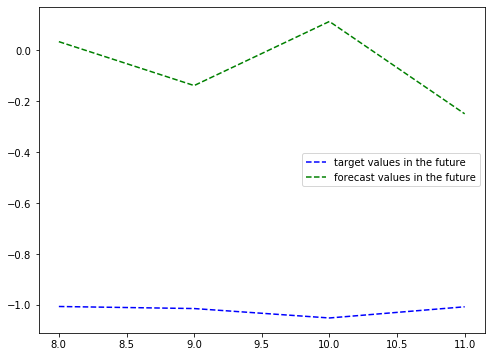

In [66]:
model.to(device)
model.eval()

for it, (signal, past_labels, targets) in enumerate(validloader):
    signal_reshaped = signal.permute(0, 2, 1).float().to(device)  
    past_labels_reshaped = past_labels.permute(0, 2, 1).float().to(device)
        
    output = model(signal_reshaped, past_labels_reshaped)
    targets = targets.view(output.size()[0], -1).float().to(device)
    loss = F.mse_loss(output, targets)
    num_samples += output.size()[0]
    loss_epoch += loss.item() * output.size()[0]
    
    plt.plot(range(window_size - label_width, window_size), targets[0].view(-1).data.numpy(), 
         color='b', linestyle='dashed', label='target values in the future')  
    plt.plot(range(window_size - label_width, window_size), output[0].view(-1).data.numpy(), 
         color='g', linestyle='dashed', label='forecast values in the future')
    plt.legend();
    break

### Use LSTM for Many-to-Many mapping.

In [127]:
class TSA_m2m_LSTM(nn.Module):
    def __init__(self, label_width, in_channels, window_length):
        super().__init__()
        layers1 = []
        layers1.append(nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1))
        layers1.append(nn.ReLU6())
        layers1.append(nn.BatchNorm1d(32))
        layers1.append(nn.Dropout(0.1))
        layers1.append(nn.LSTM(input_size=32, hidden_size=32, batch_first=True))
        self.net1 = nn.ModuleList(layers1)
        
        layers3 = []
        # Collapse all embeddings of the entire sequence (32 features for 12 time points) 
        # into one dense layer of 32*12 neurons:
        layers3.append(nn.Flatten(1))  
        layers3.append(nn.ReLU6())
        layers3.append(nn.BatchNorm1d(32*window_length))
        layers3.append(nn.Dropout(0.1))
        layers3.append(nn.Linear(in_features=32*window_length, out_features=label_width))
        self.net_out = nn.ModuleList(layers3)
    
    def forward(self, x1):
        for layer in self.net1:
            if layer._get_name() == "LSTM":
                x1 = x1.permute(0, 2, 1)  # LSTM accepts inputs in form of B*seqlen*features.
            x1 = layer(x1)
        # The output of LSTM layer is something like this: output_Bx12x32, (hn_1x32x12, cn_1x32x12). 
        # We need the output_Bx12x32 as the final embedding of the the feature sequence to pass to the next dense layer.
        x = x1[0]  
        for layer in self.net_out:
            x = layer(x)
        return x

In [128]:
model = TSA_m2m_LSTM(label_width, len(feature_columns), window_size)
lr = 0.001
wd = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [129]:
loss_vec = []
reset_loss_every = 300
n_epochs = 2
device = "cpu"

model.to(device)
model.train()

window_size = input_width + shift

for epoch in range(n_epochs+1):
    loss_epoch = 0
    num_samples = 0

    for it, (signal, past_labels, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        # Input to Cnov1d should be of size: (B, channels, length). 
        # Here channels is in fact number of features/regressors 
        # and length is size of the signal passed into the conv.
        signal_reshaped = signal.permute(0, 2, 1).float().to(device)  
        past_labels_reshaped = past_labels.permute(0, 2, 1).float().to(device)
        
        output = model(signal_reshaped)
        targets = targets.view(output.size()[0], -1).float().to(device)
        loss = F.mse_loss(output, targets)
        num_samples += output.size()[0]
        loss_epoch += loss.item() * output.size()[0]
        loss.backward()
        optimizer.step()
        
        if (it % reset_loss_every) == 0:
            print(f"epoch: {epoch}, it: {it}, average_loss: {loss_epoch/num_samples}")
            loss_epoch = 0
            num_samples = 0

#     print(f"epoch: {epoch}, num_samples: {num_samples}, average_loss: {loss_epoch / num_samples}")

    if (epoch % (n_epochs//2)) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

# Save the model and weights
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, './weights/weights_many_to_many_conv.pth')

epoch: 0, it: 0, average_loss: 1.2174735069274902
epoch: 0, it: 300, average_loss: 0.18506586487094562
epoch: 0, it: 600, average_loss: 0.11809728806838393
epoch: 0, it: 900, average_loss: 0.10213782937576374
epoch: 0, it: 1200, average_loss: 0.09327967098603646
epoch: 0, it: 1500, average_loss: 0.09076685955747962
epoch: 0, it: 1800, average_loss: 0.07949375889264047
epoch: 0, it: 2100, average_loss: 0.0785511305478091
epoch: 0, it: 2400, average_loss: 0.08221932910382748
epoch: 0, it: 2700, average_loss: 0.08957127016503363
epoch: 0, it: 3000, average_loss: 0.0844271201081574
epoch: 1, it: 0, average_loss: 0.043034423142671585
epoch: 1, it: 300, average_loss: 0.08100344721848766
epoch: 1, it: 600, average_loss: 0.08268629158070932
epoch: 1, it: 900, average_loss: 0.08118311472081889
epoch: 1, it: 1200, average_loss: 0.07496680709222953
epoch: 1, it: 1500, average_loss: 0.07939845162133376
epoch: 1, it: 1800, average_loss: 0.07459107227002582
epoch: 1, it: 2100, average_loss: 0.080664

### Evaluation on the validation set

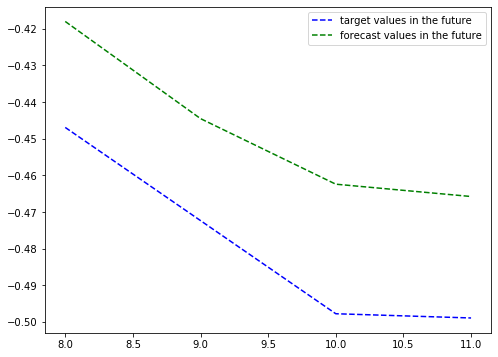

In [130]:
model.to(device)
model.eval()

for it, (signal, past_labels, targets) in enumerate(validloader):
    signal_reshaped = signal.permute(0, 2, 1).float().to(device)  
    past_labels_reshaped = past_labels.permute(0, 2, 1).float().to(device)
        
    output = model(signal_reshaped)
    targets = targets.view(output.size()[0], -1).float().to(device)
    loss = F.mse_loss(output, targets)
    num_samples += output.size()[0]
    loss_epoch += loss.item() * output.size()[0]
    
    plt.plot(range(window_size - label_width, window_size), targets[0].view(-1).data.numpy(), 
         color='b', linestyle='dashed', label='target values in the future')  
    plt.plot(range(window_size - label_width, window_size), output[0].view(-1).data.numpy(), 
         color='g', linestyle='dashed', label='forecast values in the future')
    plt.legend();
    break

### Use AutoRegressive method

### Denser model with two layers of Conv1d

### Simultaneously forecast multiple signals

Using https://louisenaud.github.io/time_series_prediction.html ?